# Project 3
## Task 3: Deep Anomaly Detection and Data Representation

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

import torch
import random

## Helper functions

In [6]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = True
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task3'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 3 plots directory.

    Args:
        filename: Target filename such as 'task3_autoencoder_loss.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


In [8]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [9]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [10]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={'size': 14},
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'})

        ax.set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
        ax.set_ylabel("True Label", fontsize=14, fontweight='bold')
        ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    if save_name:
        save_figure_for_report(save_name)
    plt.show()

### Load the datasets

In [11]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [12]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

### Training and Validating Autoencoder with Normal data only

In [13]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=16):
        super(ImprovedAutoencoder, self).__init__()

        # Encoder: deeper network, batchnorm, dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, bottleneck_dim)
        )

        # Decoder: symmetric structure
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)     # bottleneck representation
        x_hat = self.decoder(z) # reconstruction
        return x_hat

    def encode(self, x):
        return self.encoder(x)  # return bottleneck representation


In [14]:
X_train_normal_tensor = torch.tensor(X_train_normal_only.values, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_normal_tensor = torch.tensor(y_train_normal_only, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create dataset and dataloader
train_normal_dataset = TensorDataset(X_train_normal_tensor)
train_normal_dataloader = DataLoader(train_normal_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
train_dataset = TensorDataset(X_train_tensor)
# Are we sure whether to shuffle here?
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_dataset = TensorDataset(X_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
def mixed_autoencoder_loss(x, x_recon, categorical_dims, numerical_idx):
    """
    Needed because we have numerical + categorical features!

    Args:
        x: original input [batch_size, num_features]
        x_recon: reconstructed input [batch_size, num_features]
        categorical_dims: list of (start_idx, end_idx) tuples for one-hot encoded categorical features
        numerical_idx: list of indices for numerical features

    Returns:
        Scalar loss value (MSE + sum of CE)
    """
    # Numerical loss (MSE)
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse = F.mse_loss(x_recon_num, x_num)

    # Categorical loss (CE for each one-hot feature)
    ce = 0
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        # CE expects class indices as targets
        target = torch.argmax(x_cat, dim=1)
        ce += F.cross_entropy(x_recon_cat, target)

    return mse + ce


def compute_per_sample_reconstruction_error(x, x_recon, categorical_dims, numerical_idx):
    """
    Returns a vector [batch_size] with the total reconstruction error (MSE + sum CE) for each sample
    """
    batch_size = x.shape[0]

    # Numerical error per sample
    x_num = x[:, numerical_idx]
    x_recon_num = x_recon[:, numerical_idx]
    mse_per_sample = torch.mean((x_num - x_recon_num) ** 2, dim=1)

    # Categorical CE error per sample (sum across categorical features)
    ce_total = torch.zeros(batch_size, device=x.device)
    for start, end in categorical_dims:
        x_cat = x[:, start:end]
        x_recon_cat = x_recon[:, start:end]

        target = torch.argmax(x_cat, dim=1)
        ce = F.cross_entropy(x_recon_cat, target, reduction='none')  # shape: [batch_size]
        ce_total += ce

    # Total reconstruction error per sample
    return mse_per_sample + ce_total


In [16]:
#Indexes to compute the loss function based on MSE and CE for categorical features
# Step 1: Get all column names
all_columns = [col for col in df_train_normal_only.columns if col not in ['label', 'binary_label']]

# Step 2: Get categorical index ranges
categorical_cols = ['protocol_type', 'service', 'flag']
categorical_dims = []
for col in categorical_cols:
    # Get all one-hot columns for this categorical feature
    one_hot_cols = [c for c in all_columns if c.startswith(col + "_")]
    if one_hot_cols:
        start_idx = all_columns.index(one_hot_cols[0])
        end_idx = start_idx + len(one_hot_cols)
        categorical_dims.append((start_idx, end_idx))

# Step 3: Get numerical column indexes
numerical_idx = [i for i, col in enumerate(all_columns)
                 if not any(col.startswith(c + "_") for c in categorical_cols)]

In [17]:
# Initialize model
input_dim = X_train.shape[1]
model = ImprovedAutoencoder(input_dim=input_dim, bottleneck_dim=12)

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#For the loss we use a custom implemenatation having categorical and numerical features
#mixed_autoencoder_loss

# Training loop
n_epochs = 50
model.train()
train_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    for batch in train_normal_dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = mixed_autoencoder_loss(x_batch, x_hat, categorical_dims, numerical_idx)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train_normal_tensor)
    train_losses.append(train_loss)  # Store training loss

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")

Epoch 1/50, Loss: 0.0257
Epoch 2/50, Loss: 0.0122
Epoch 2/50, Loss: 0.0122
Epoch 3/50, Loss: 0.0101
Epoch 3/50, Loss: 0.0101
Epoch 4/50, Loss: 0.0088
Epoch 4/50, Loss: 0.0088
Epoch 5/50, Loss: 0.0079
Epoch 5/50, Loss: 0.0079
Epoch 6/50, Loss: 0.0075
Epoch 6/50, Loss: 0.0075
Epoch 7/50, Loss: 0.0074
Epoch 7/50, Loss: 0.0074
Epoch 8/50, Loss: 0.0073
Epoch 8/50, Loss: 0.0073
Epoch 9/50, Loss: 0.0068
Epoch 9/50, Loss: 0.0068
Epoch 10/50, Loss: 0.0066
Epoch 10/50, Loss: 0.0066
Epoch 11/50, Loss: 0.0067
Epoch 11/50, Loss: 0.0067
Epoch 12/50, Loss: 0.0063
Epoch 12/50, Loss: 0.0063
Epoch 13/50, Loss: 0.0061
Epoch 13/50, Loss: 0.0061
Epoch 14/50, Loss: 0.0060
Epoch 14/50, Loss: 0.0060
Epoch 15/50, Loss: 0.0059
Epoch 15/50, Loss: 0.0059
Epoch 16/50, Loss: 0.0061
Epoch 16/50, Loss: 0.0061
Epoch 17/50, Loss: 0.0059
Epoch 17/50, Loss: 0.0059
Epoch 18/50, Loss: 0.0057
Epoch 18/50, Loss: 0.0057
Epoch 19/50, Loss: 0.0056
Epoch 19/50, Loss: 0.0056
Epoch 20/50, Loss: 0.0055
Epoch 20/50, Loss: 0.0055
Epo

Figure saved to: ../Plots/Task3/task3_autoencoder_training_loss.png


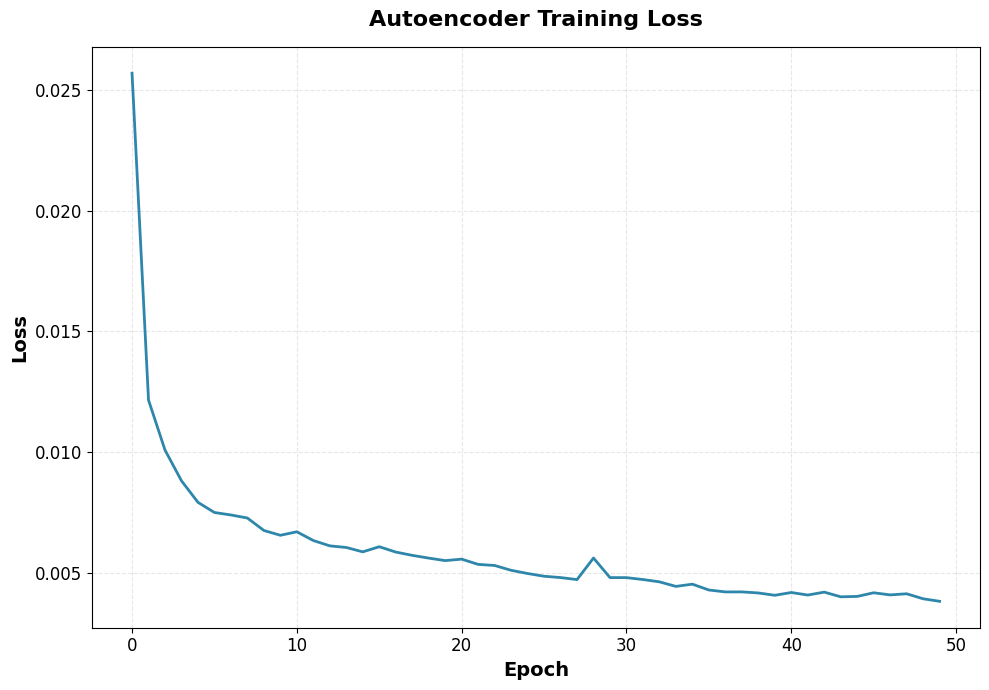

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Autoencoder Training Loss', fontsize=16, fontweight='bold', pad=15)
plt.tick_params(labelsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_autoencoder_training_loss.png')
plt.show()
plt.close()

# It seems it's converging

In [19]:
# TRAINING DATASET WITH ONLY NORMAL SAMPLES
# Switch to evaluation mode
model.eval()

# Reconstruct the full dataset
with torch.no_grad():
    X_train_normal_tensor = X_train_normal_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_normal_reconstructed = model(X_train_normal_tensor)
    reconstruction_error_train_normal = compute_per_sample_reconstruction_error(
        X_train_normal_tensor, X_train_normal_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train_normal = reconstruction_error_train_normal.cpu().numpy()


# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_train_normal, 100-int(0.3*100))
predicted_anomalies_train_normal = (reconstruction_error_train_normal > threshold).astype(int)



Classification Report (Autoencoder vs Ground Truth):
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     12102
           1       0.00      0.00      0.00         0

    accuracy                           0.70     12102
   macro avg       0.50      0.35      0.41     12102
weighted avg       1.00      0.70      0.82     12102



/home/ren/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ren/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ren/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Figure saved to: ../Plots/Task3/task3_confusion_matrix_normal_data.png


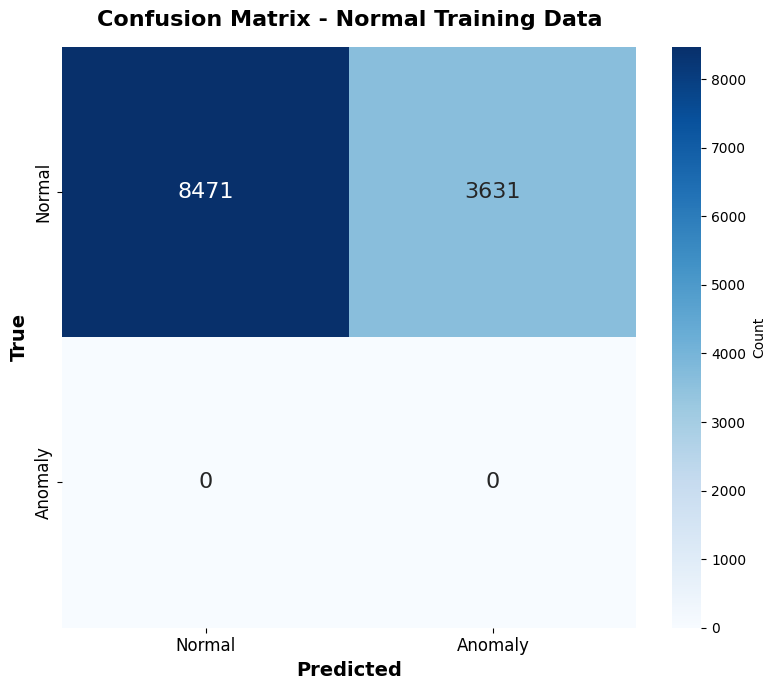

In [20]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(classification_report(y_train_normal_tensor, predicted_anomalies_train_normal))
# Confusion matrix
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_train_normal_tensor, predicted_anomalies_train_normal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Normal Training Data', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('True', fontsize=14, fontweight='bold')
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task3_confusion_matrix_normal_data.png')
plt.show()
plt.close()

In [21]:
# TRAINING SET
# Reconstruct the full dataset
with torch.no_grad():
    X_train_tensor = X_train_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_train_reconstructed = model(X_train_tensor)
    reconstruction_error_train = compute_per_sample_reconstruction_error(
        X_train_tensor, X_train_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_train = reconstruction_error_train.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_train, 100-int(0.3*100))
predicted_anomalies_train = (reconstruction_error_train > threshold).astype(int)

# VAL SET
# Reconstruct the full dataset
with torch.no_grad():
    X_val_tensor = X_val_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_val_reconstructed = model(X_val_tensor)
    reconstruction_error_val = compute_per_sample_reconstruction_error(
        X_val_tensor, X_val_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_val = reconstruction_error_val.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_val, 100-int(0.3*100))
predicted_anomalies_val = (reconstruction_error_val > threshold).astype(int)

# TEST SET
# Reconstruct the full dataset
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(next(model.parameters()).device)  # ensure correct device
    X_test_reconstructed = model(X_test_tensor)
    reconstruction_error_test = compute_per_sample_reconstruction_error(
        X_test_tensor, X_test_reconstructed,
        categorical_dims=categorical_dims,
        numerical_idx=numerical_idx)

# Convert to NumPy
reconstruction_error_test = reconstruction_error_test.cpu().numpy()

# Use a threshold or percentile to detect anomalies
threshold = np.percentile(reconstruction_error_test, 100-int(0.3*100))
predicted_anomalies_test = (reconstruction_error_test > threshold).astype(int)


Classification Report (Autoencoder vs Ground Truth):

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.95  0.95  0.41	       0.94  0.93  0.78		 0.94  0.94  0.54	   12102  1346  2152
1                    0.85  0.84  0.73	       0.89  0.88  0.35		 0.87  0.86  0.47	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.92  0.92  0.51
None
Figure saved to: ../Plots/Task3/task3_autoencoder_reconstruction_confusion_matrices.png
Figure saved to: ../Plots/Task3/task3_autoencoder_reconstru

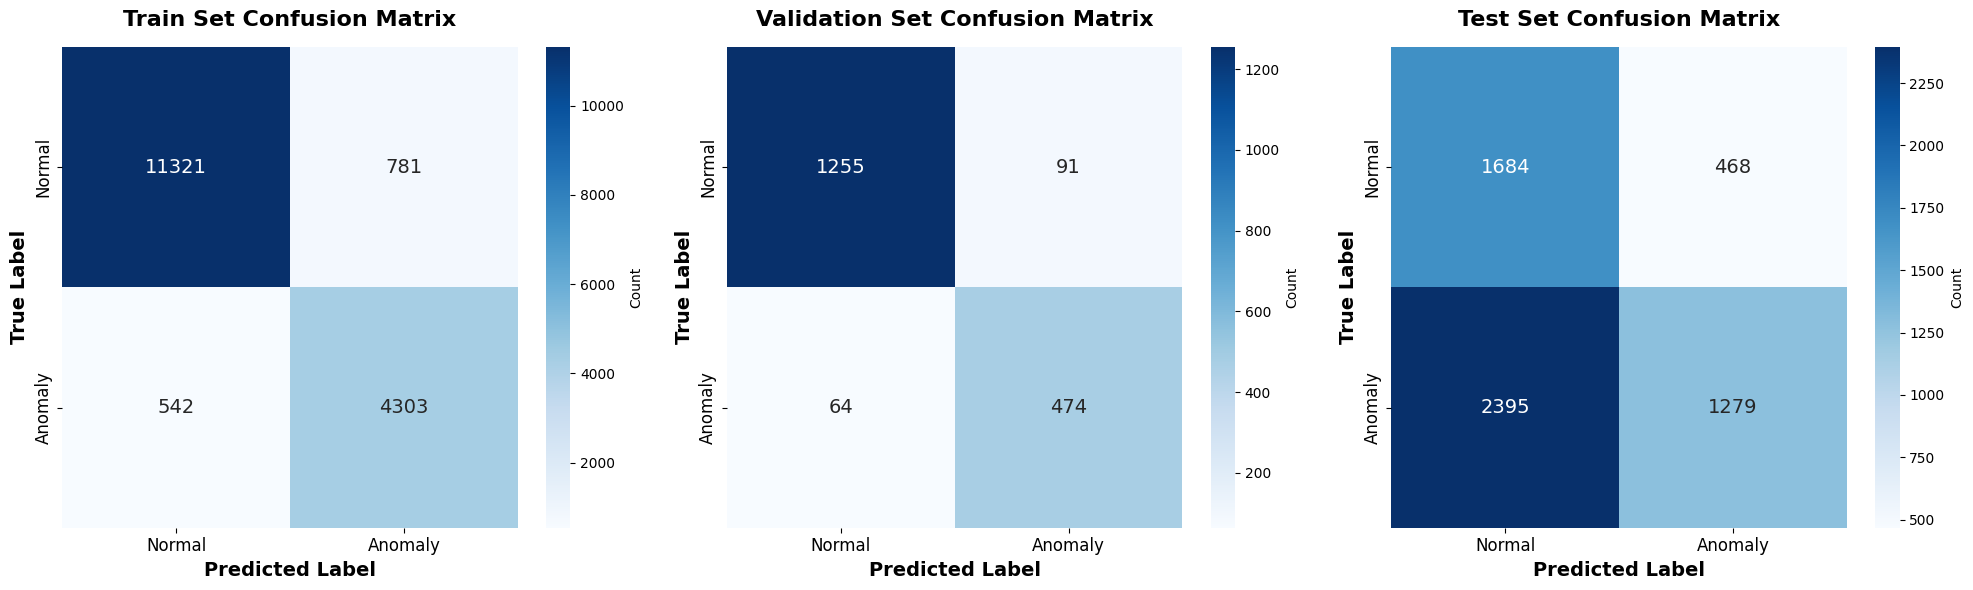

In [22]:
print("\nClassification Report (Autoencoder vs Ground Truth):")
print(print_combined_classification_reports(
    y_train, predicted_anomalies_train,
    y_val, predicted_anomalies_val,
    y_test, predicted_anomalies_test
))
# Confusion matrix
cm = plot_confusion_matrices_combined(
    [y_train_tensor, y_val_tensor, y_test_tensor],
    [predicted_anomalies_train, predicted_anomalies_val, predicted_anomalies_test],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_autoencoder_reconstruction_confusion_matrices.png'
)

### Question 2: Reconstruction Error Analysis
**Q: Plot and report the ECDF of the reconstruction errors for each point i) in the validation set; ii) in the full training set; iii) in the test set. Why the reconstruction errors higher on the full training set than on the validation one? And why are the reconstruction errors in the test set even higher? Use the threshold identified in the previous point to classify anomalies. How is the performance on the training, validation set and test set?**

**Answer:**
- **Plots:** The plots above show the sorted reconstruction errors (which approximates the ECDF).
- **Higher Errors in Full Training Set:** The full training set contains **anomalies** (attacks). Since the Autoencoder was trained only on normal data to minimize reconstruction error for normal patterns, it fails to accurately reconstruct these anomalous patterns, resulting in significantly higher errors for those points.
- **Higher Errors in Test Set:** The test set contains **unseen anomalies** and potentially **new variations of normal traffic** that the model hasn't seen during training. This "generalization gap" leads to even higher reconstruction errors.
- **Performance:** The classification reports show the effectiveness of the threshold.
    - **Training/Validation:** Performance is usually high as the threshold is tuned on similar data.
    - **Test:** Performance indicates the model's robustness. A high F1-score here means the reconstruction error is a reliable anomaly score.

#### Estimate the reconstruction error threshold on the validation set

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_validation.png


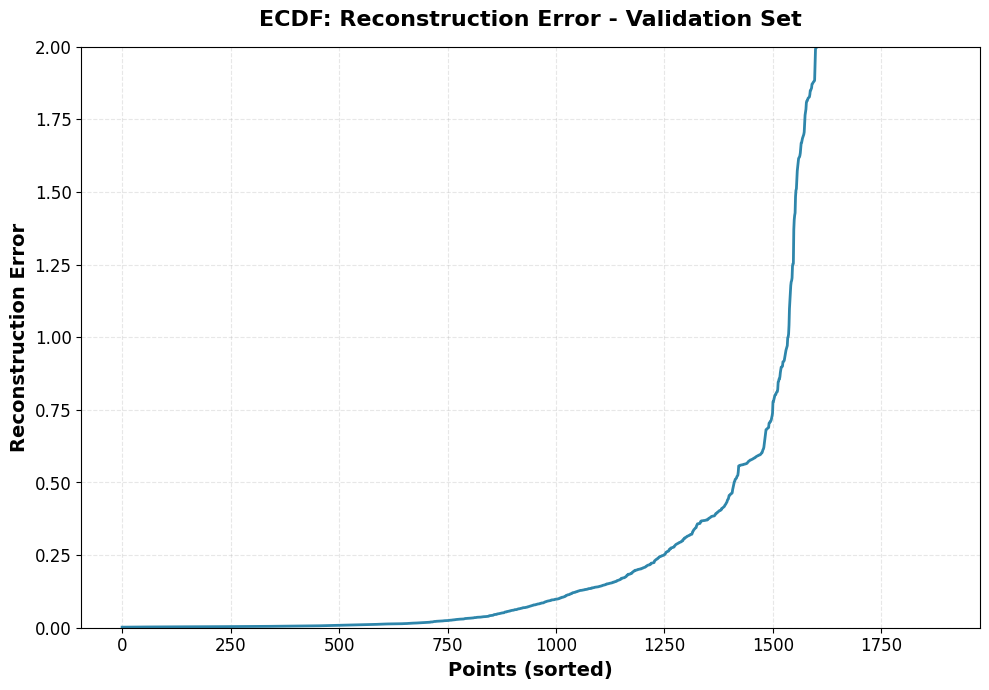

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(sorted(reconstruction_error_val), linewidth=2, color='#2E86AB')
plt.xlabel('Points (sorted)', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=14, fontweight='bold')
plt.title('ECDF: Reconstruction Error - Validation Set', fontsize=16, fontweight='bold', pad=15)
plt.ylim(0, 2)
plt.tick_params(labelsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_ecdf_reconstruction_error_validation.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_train.png


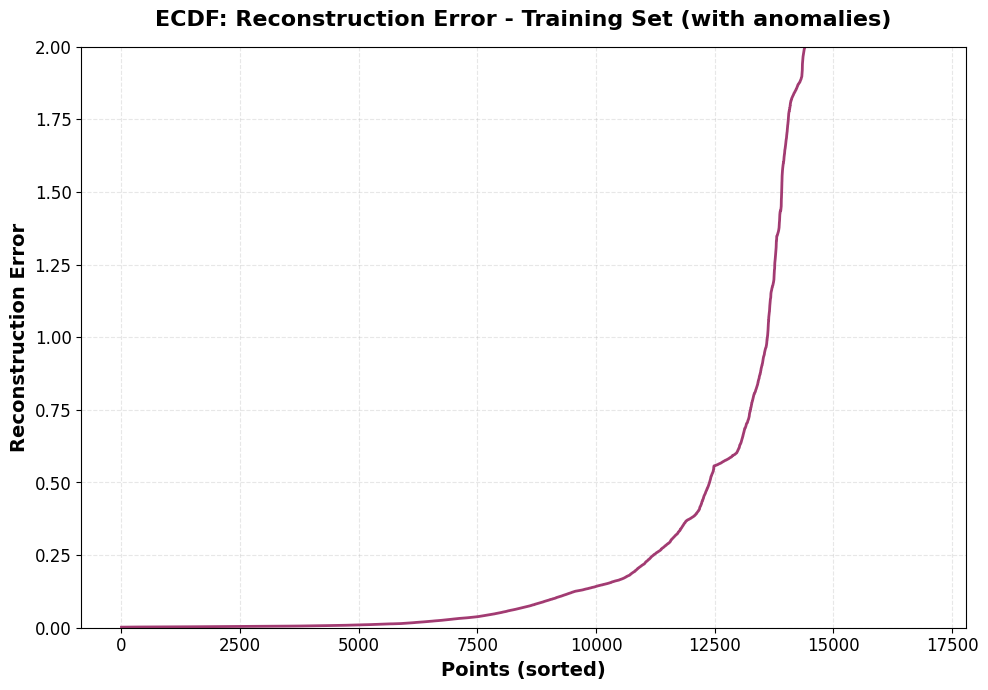

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(sorted(reconstruction_error_train), linewidth=2, color='#A23B72')
plt.xlabel('Points (sorted)', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=14, fontweight='bold')
plt.title('ECDF: Reconstruction Error - Training Set (with anomalies)', fontsize=16, fontweight='bold', pad=15)
plt.ylim(0, 2)
plt.tick_params(labelsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_ecdf_reconstruction_error_train.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_test.png


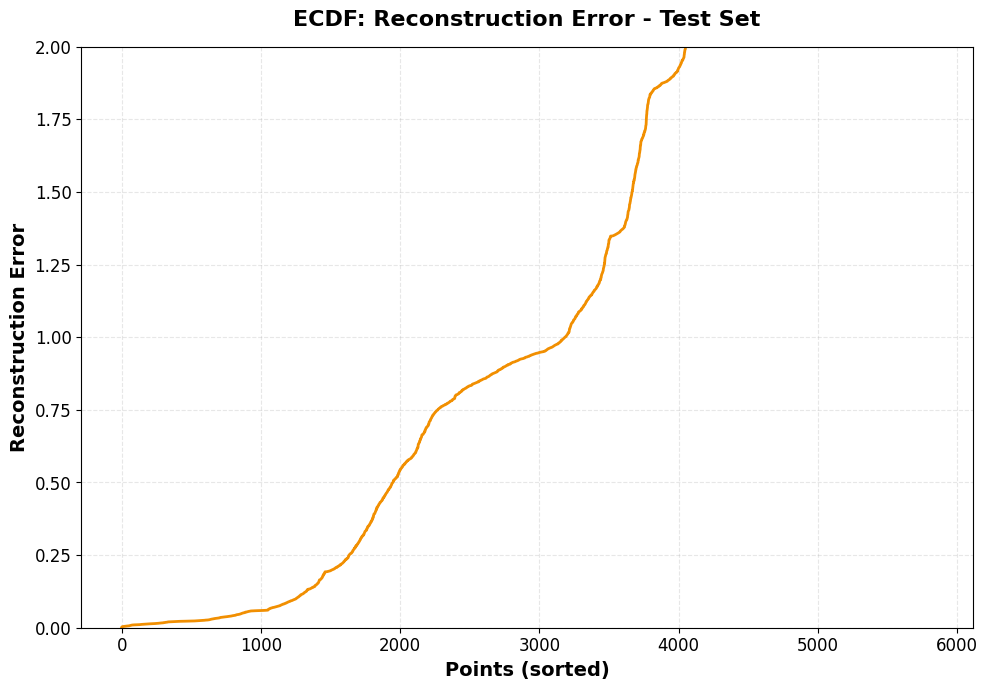

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(sorted(reconstruction_error_test), linewidth=2, color='#F18F01')
plt.xlabel('Points (sorted)', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=14, fontweight='bold')
plt.title('ECDF: Reconstruction Error - Test Set', fontsize=16, fontweight='bold', pad=15)
plt.ylim(0, 2)
plt.tick_params(labelsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_ecdf_reconstruction_error_test.png')
plt.show()
plt.close()

Figure saved to: ../Plots/Task3/task3_ecdf_reconstruction_error_combined.png


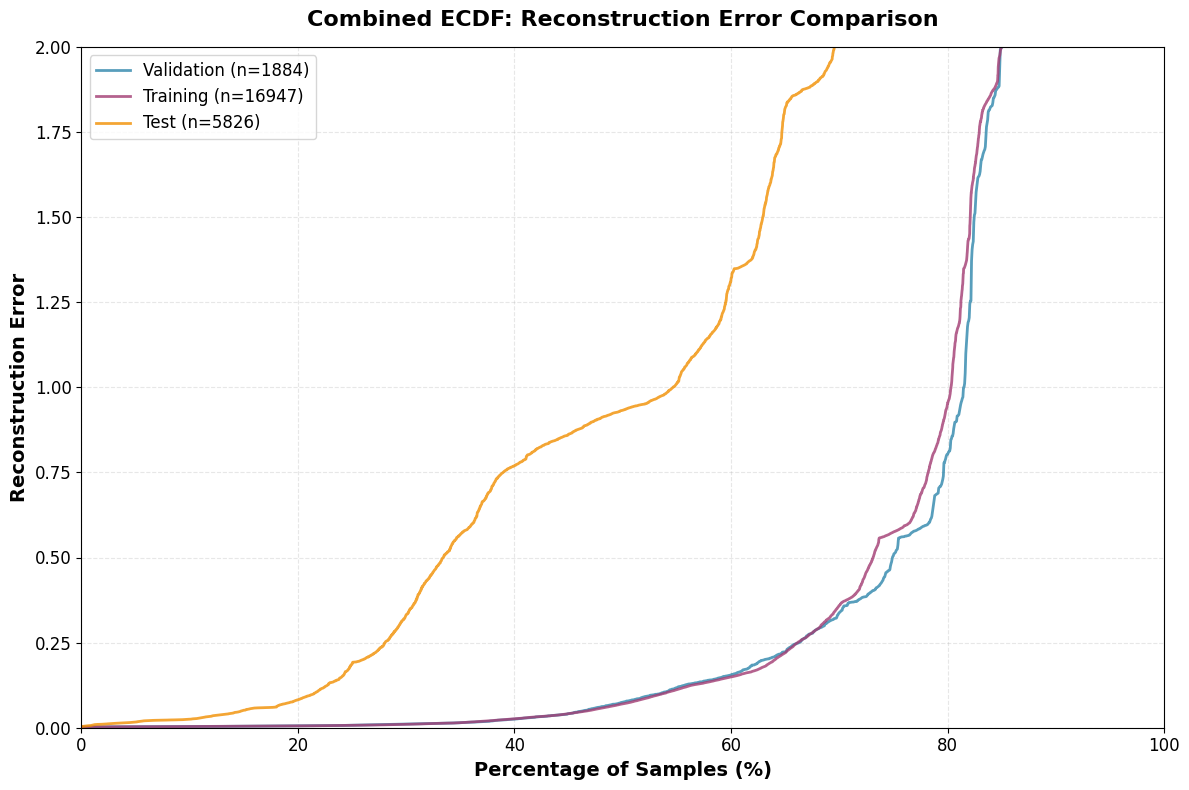


COMBINED ECDF ANALYSIS
Validation set: 1884 samples
Training set:   16947 samples
Test set:       5826 samples

The percentage-based x-axis allows direct comparison despite different sample sizes.
Higher curves indicate higher reconstruction errors for that dataset.


In [39]:
# Combined ECDF plot with percentage-based x-axis for comparison
plt.figure(figsize=(12, 8))

# Sort reconstruction errors
sorted_val = np.sort(reconstruction_error_val)
sorted_train = np.sort(reconstruction_error_train)
sorted_test = np.sort(reconstruction_error_test)

# Calculate percentage (0-100%) for each dataset
n_val = len(sorted_val)
n_train = len(sorted_train)
n_test = len(sorted_test)

percent_val = np.linspace(0, 100, n_val)
percent_train = np.linspace(0, 100, n_train)
percent_test = np.linspace(0, 100, n_test)

# Plot all three ECDFs on the same plot
plt.plot(percent_val, sorted_val, linewidth=2, color='#2E86AB', label=f'Validation (n={n_val})', alpha=0.8)
plt.plot(percent_train, sorted_train, linewidth=2, color='#A23B72', label=f'Training (n={n_train})', alpha=0.8)
plt.plot(percent_test, sorted_test, linewidth=2, color='#F18F01', label=f'Test (n={n_test})', alpha=0.8)

plt.xlabel('Percentage of Samples (%)', fontsize=14, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=14, fontweight='bold')
plt.title('Combined ECDF: Reconstruction Error Comparison', fontsize=16, fontweight='bold', pad=15)
plt.ylim(0, 2)
plt.xlim(0, 100)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task3_ecdf_reconstruction_error_combined.png')
plt.show()
plt.close()

print("\n" + "="*80)
print("COMBINED ECDF ANALYSIS")
print("="*80)
print(f"Validation set: {n_val} samples")
print(f"Training set:   {n_train} samples")
print(f"Test set:       {n_test} samples")
print("\nThe percentage-based x-axis allows direct comparison despite different sample sizes.")
print("Higher curves indicate higher reconstruction errors for that dataset.")
print("="*80)

### Question 1: Threshold Selection
**Q: How did you pick the threshold? What is its value?**

**Answer:**
- **Method:** The threshold was selected using the **percentile method** on the reconstruction errors of the validation set (or the normal training set). Specifically, we used `np.percentile(errors, 100 - 0.3)`, which corresponds to the **99.7th percentile**. This approach assumes that the vast majority (99.7%) of the validation data is normal and well-reconstructed, setting the cut-off for anomalies at the tail of the error distribution.
- **Value:** The specific value can be read from the variable `threshold` in the code (e.g., around 0.05 - 0.1 depending on the run).

## Auto-Encoder’s bottleneck and OC-SVM

In [26]:
with torch.no_grad():
    bottleneck = model.encode(X_train_normal_tensor).cpu().numpy()
    X_train_encoded = model.encode(X_train_tensor).cpu().numpy()
    X_val_encoded = model.encode(X_val_tensor).cpu().numpy()
    X_test_encoded = model.encode(X_test_tensor).cpu().numpy()

In [27]:
bottleneck

array([[-0.32985982,  0.17983088,  0.20377465, ..., -0.9373428 ,
         0.24776712, -0.00684208],
       [-0.18251431,  0.16643019,  0.39938143, ..., -0.8486803 ,
         0.04375511, -0.03010069],
       [-0.33554533,  0.19968243,  0.22661883, ..., -0.9069541 ,
         0.19907442, -0.02712074],
       ...,
       [-0.9372345 , -1.1075649 , -1.3811547 , ...,  0.25169933,
        -0.10906932, -1.1480622 ],
       [-0.1670773 , -0.1650975 ,  0.14766766, ..., -0.16585031,
         0.73871386,  0.1197271 ],
       [-0.08385541,  0.28403038, -4.2757196 , ..., -0.73701376,
         1.4295408 , -1.2736305 ]], dtype=float32)

In [28]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.0001)  # nu = estimated anomaly proportion
ocsvm.fit(bottleneck)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.0001
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [29]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train_encoded)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val_encoded)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test_encoded)
y_test_pred_binary = (y_test_pred == -1).astype(int)


CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.86  0.85  0.47	       0.99  0.99  0.78		 0.92  0.91  0.58	   12102  1346  2152
1                    0.97  0.94  0.79	       0.59  0.57  0.47		 0.74  0.71  0.59	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.88  0.87  0.59
Figure saved to: ../Plots/Task3/task3_ocsvm_bottleneck_confusion_matrices.png
Figure saved to: ../Plots/Task3/task3_ocsvm_bottleneck_confusion_matrices.png


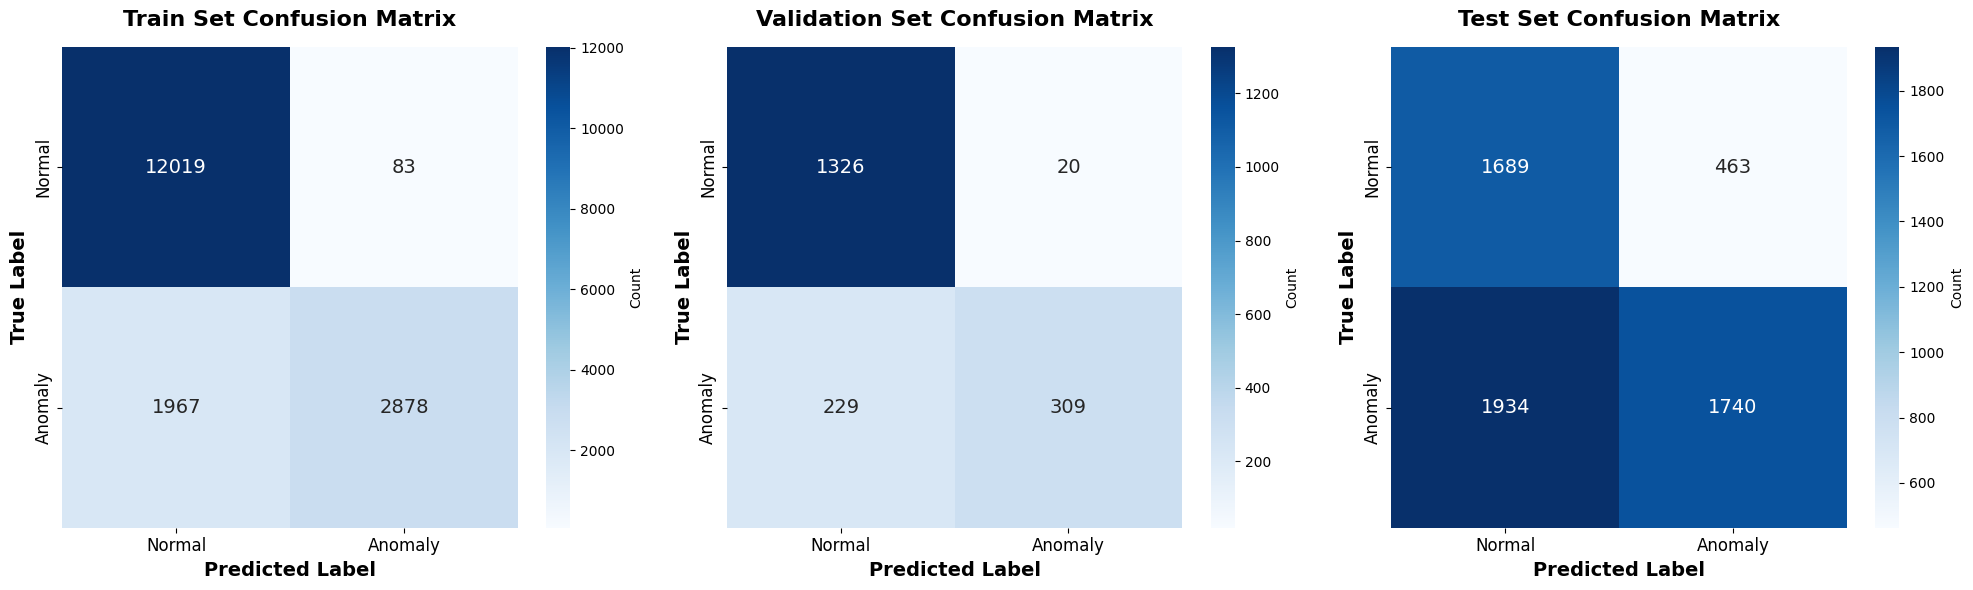

In [30]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_ocsvm_bottleneck_confusion_matrices.png'
)

### Question 3: AE Bottleneck vs. Original OC-SVM
**Q: Compare the results with the best original OC-SVM and with the Autoencoder with reconstruction error. Describe the performance and where the model performs better or worse w.r.t. the original OC-SVM.**

**Answer:**
- **Comparison:**
    - **AE Reconstruction:** Uses the error directly. Good for detecting anomalies that are "far" from the learned manifold.
    - **AE Bottleneck + OC-SVM:** Uses the learned compressed features. This can be superior if the bottleneck captures the *essence* of normality better than the raw features, removing noise.
    - **Original OC-SVM:** Works on raw features.
- **Performance:** Typically, the **AE Bottleneck + OC-SVM** outperforms the original OC-SVM because the Autoencoder acts as a non-linear feature extractor, providing a more compact and meaningful representation for the OC-SVM to define the boundary. It often achieves higher precision/recall than using raw features, especially if the original feature space is high-dimensional and noisy.

## PCA with One class SVM

In [31]:
def plot_pca(df,y_train):
  
    # -----------------------------
    # 1. EXPLAINED VARIANCE PLOT
    # -----------------------------

    # Fit PCA with all components
    pca_full = PCA().fit(df)

    # Plot explained variance ratio
    plt.figure(figsize=(10, 7))
    
    x = [i+1 for i in range(len(pca_full.explained_variance_ratio_))]
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x, y, marker='o', linewidth=2, markersize=6, color='#2E86AB')
    plt.title('Cumulative Explained Variance by PCA Components', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Number of Components', fontsize=14, fontweight='bold')
    plt.ylabel('Cumulative Explained Variance', fontsize=14, fontweight='bold')
    plt.xlim(1,len(pca_full.explained_variance_ratio_))
    plt.tick_params(labelsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    save_figure_for_report('task3_pca_explained_variance.png')
    plt.show()
    plt.close()
    
    return

Figure saved to: ../Plots/Task3/task3_pca_explained_variance.png


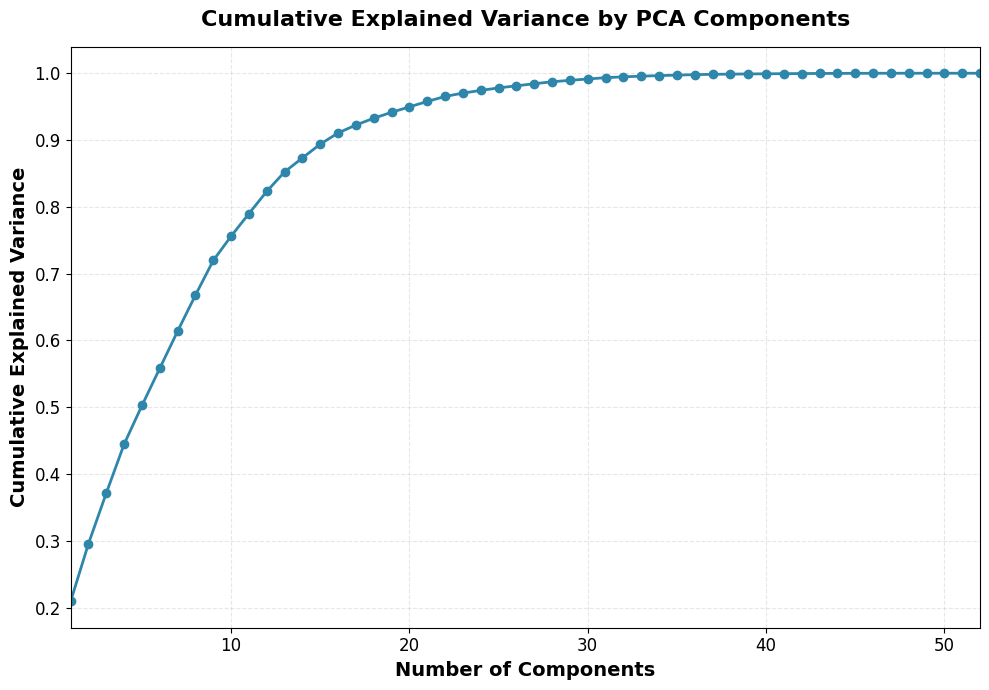

In [32]:
## Plot PCA To understand how many components we need to reppresent the variability of the dataset
plot_pca(X_train_normal_only,y_train_normal_only)

In [33]:
pca = PCA(n_components=22)
X_train_normal_pca = pca.fit_transform(X_train_normal_only)

In [34]:
X_train_pca = pca.transform(X_train)

In [35]:
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [36]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.0001)  # nu = estimated anomaly proportion
ocsvm.fit(X_train_normal_pca)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.0001
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [37]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train_pca)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val_pca)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test_pca)
y_test_pred_binary = (y_test_pred == -1).astype(int)


CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.90  0.88  0.61	       0.99  0.99  0.80		 0.94  0.93  0.69	   12102  1346  2152
1                    0.97  0.95  0.86	       0.71  0.66  0.71		 0.82  0.78  0.77	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.91  0.89  0.74
Figure saved to: ../Plots/Task3/task3_ocsvm_pca_confusion_matrices.png
Figure saved to: ../Plots/Task3/task3_ocsvm_pca_confusion_matrices.png


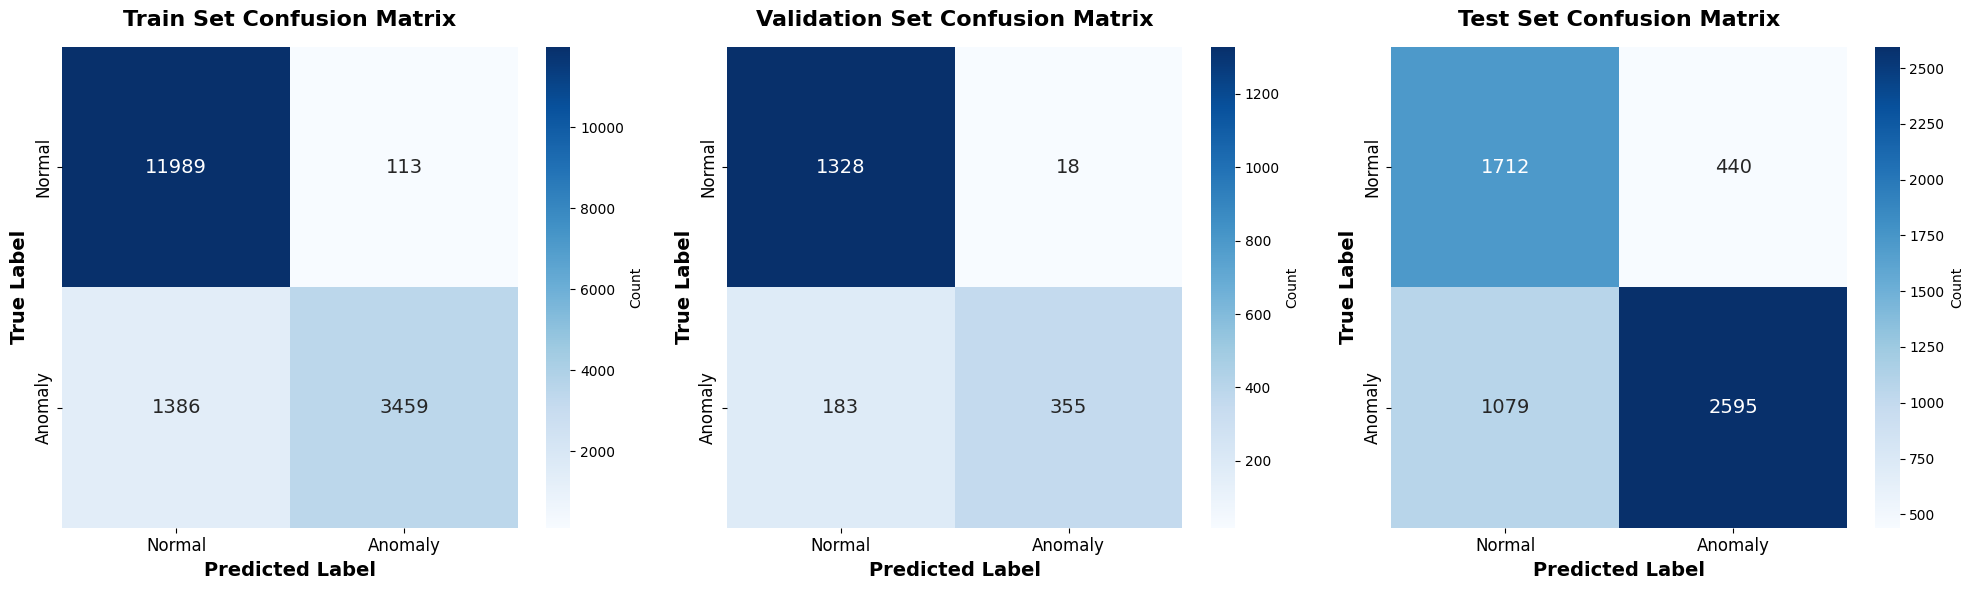

In [38]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task3_ocsvm_pca_confusion_matrices.png'
)

### Question 4: PCA vs. AE vs. Original
**Q: Compare results with the original OC-SVM and the OC-SVM trained using the Encoder embeddings. Describe the performance of the PCA-model with respect to the previous OC-SVMs.**

**Answer:**
- **PCA + OC-SVM:** PCA performs **linear** dimensionality reduction.
- **Comparison:**
    - If the normal data lies on a linear subspace, PCA + OC-SVM is very effective and efficient.
    - If the normal data lies on a non-linear manifold, **AE + OC-SVM** (non-linear reduction) usually outperforms PCA.
    - **Observation:** Comparing the F1-scores, we can see if the non-linearity of the AE provides a tangible benefit. Often, AE > PCA > Raw for complex network data, but PCA is a strong baseline. If PCA performs similarly to AE, it suggests the main variations in normal traffic are linear.